In [2]:
!pip install torch torchvision matplotlib scikit-learn tqdm


  Using cached torch-2.9.0-cp312-cp312-manylinux_2_28_x86_64.whl.metadata (30 kB)
  Using cached torchvision-0.24.0-cp312-cp312-manylinux_2_28_x86_64.whl.metadata (5.9 kB)
  Using cached tqdm-4.67.1-py3-none-any.whl.metadata (57 kB)
  Using cached filelock-3.20.0-py3-none-any.whl.metadata (2.1 kB)
  Using cached setuptools-80.9.0-py3-none-any.whl.metadata (6.6 kB)
  Using cached sympy-1.14.0-py3-none-any.whl.metadata (12 kB)
  Using cached networkx-3.5-py3-none-any.whl.metadata (6.3 kB)
  Using cached fsspec-2025.9.0-py3-none-any.whl.metadata (10 kB)
  Using cached nvidia_cuda_nvrtc_cu12-12.8.93-py3-none-manylinux2010_x86_64.manylinux_2_12_x86_64.whl.metadata (1.7 kB)
  Using cached nvidia_cuda_runtime_cu12-12.8.90-py3-none-manylinux2014_x86_64.manylinux_2_17_x86_64.whl.metadata (1.7 kB)
  Using cached nvidia_cuda_cupti_cu12-12.8.90-py3-none-manylinux2014_x86_64.manylinux_2_17_x86_64.whl.metadata (1.7 kB)
  Using cached nvidia_cudnn_cu12-9.10.2.21-py3-none-manylinux_2_27_x86_64.whl.met

## Necessary Configurations to use VAE

In [3]:
# --- Imports e configurações ---
import os
import math
import torch
from torch import nn, optim
from torch.utils.data import random_split, DataLoader
from torchvision import datasets, transforms, utils
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# --- Hyperparâmetros principais (modifique aqui) ---
dataset_name = "MNIST"            # "MNIST" ou "FashionMNIST"
batch_size = 128
lr = 1e-3
num_epochs = 20
latent_dim = 2                    # comece em 2 para visualizar; experimente 8,16,32
hidden_dim = 512
seed = 42
torch.manual_seed(seed)


Device: cuda


## Data Preparation & Slit Data

In [4]:
# --- Data preparation ---
transform = transforms.Compose([
    transforms.ToTensor(),         # [0,1]
])

if dataset_name.upper() == "MNIST":
    ds = datasets.MNIST(".", train=True, download=True, transform=transform)
    ds_test = datasets.MNIST(".", train=False, download=True, transform=transform)
else:
    ds = datasets.FashionMNIST(".", train=True, download=True, transform=transform)
    ds_test = datasets.FashionMNIST(".", train=False, download=True, transform=transform)

# split train -> train/val
val_size = int(0.1 * len(ds))
train_size = len(ds) - val_size
train_ds, val_ds = random_split(ds, [train_size, val_size])

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)
test_loader = DataLoader(ds_test, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)

img_shape = next(iter(train_loader))[0].shape[1:]  # channels, H, W
input_dim = int(np.prod(img_shape))
print("Image shape:", img_shape, "input_dim:", input_dim)


100%|██████████| 9.91M/9.91M [00:05<00:00, 1.88MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 216kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.02MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 6.65MB/s]


Image shape: torch.Size([1, 28, 28]) input_dim: 784


## VAE Model

In [5]:
# --- VAE model ---
class Encoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Flatten(),
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
        )
        self.fc_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim, latent_dim)

    def forward(self, x):
        h = self.net(x)
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar

class Decoder(nn.Module):
    def __init__(self, latent_dim, hidden_dim, output_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim),
            nn.Sigmoid()   # output in [0,1] for BCE loss / images normalized
        )
        self.output_dim = output_dim

    def forward(self, z):
        x_hat = self.net(z)
        x_hat = x_hat.view(-1, *img_shape)
        return x_hat

# reparameterization trick
def reparameterize(mu, logvar):
    # sample z ~ N(mu, sigma^2) by z = mu + eps * sigma
    sigma = (0.5 * logvar).exp()
    eps = torch.randn_like(sigma)
    return mu + eps * sigma

class VAE(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super().__init__()
        self.encoder = Encoder(input_dim, hidden_dim, latent_dim)
        self.decoder = Decoder(latent_dim, hidden_dim, input_dim)

    def forward(self, x):
        mu, logvar = self.encoder(x)
        z = reparameterize(mu, logvar)
        x_hat = self.decoder(z)
        return x_hat, mu, logvar, z

model = VAE(input_dim, hidden_dim, latent_dim).to(device)


In [6]:
# --- Loss function ---
# Reconstruction: binary cross-entropy (pixel-wise) or MSE. For MNIST, BCE is common.
reconstruction_loss_fn = nn.BCELoss(reduction="sum")  # sum over pixels

def vae_loss(x, x_hat, mu, logvar):
    # Reconstruction term (sum over pixels and batch)
    recon_loss = reconstruction_loss_fn(x_hat, x)
    # KL divergence between q(z|x)=N(mu, sigma^2) and p(z)=N(0,I)
    # analytical form: -0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    kld = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + kld, recon_loss, kld


## --- Training utilities ---

In [ ]:

optimizer = optim.Adam(model.parameters(), lr=lr)

def train_epoch(model, loader, optimizer):
    model.train()
    total_loss = 0.0
    total_recon = 0.0
    total_kld = 0.0
    for x, _ in loader:
        x = x.to(device)
        optimizer.zero_grad()
        x_hat, mu, logvar, _ = model(x)
        loss, recon, kld = vae_loss(x, x_hat, mu, logvar)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        total_recon += recon.item()
        total_kld += kld.item()
    n = len(loader.dataset)
    return total_loss / n, total_recon / n, total_kld / n

def eval_epoch(model, loader):
    model.eval()
    total_loss = 0.0
    total_recon = 0.0
    total_kld = 0.0
    with torch.no_grad():
        for x, _ in loader:
            x = x.to(device)
            x_hat, mu, logvar, _ = model(x)
            loss, recon, kld = vae_loss(x, x_hat, mu, logvar)
            total_loss += loss.item()
            total_recon += recon.item()
            total_kld += kld.item()
    n = len(loader.dataset)
    return total_loss / n, total_recon / n, total_kld / n


## Train loop (salve checkpoints e reconstructions)

In [ ]:
out_dir = "vae_outputs"
os.makedirs(out_dir, exist_ok=True)

train_logs = []
val_logs = []

for epoch in range(1, num_epochs + 1):
    train_loss, train_recon, train_kld = train_epoch(model, train_loader, optimizer)
    val_loss, val_recon, val_kld = eval_epoch(model, val_loader)
    train_logs.append((train_loss, train_recon, train_kld))
    val_logs.append((val_loss, val_recon, val_kld))
    print(f"Epoch {epoch}/{num_epochs} | train loss {train_loss:.4f} (recon {train_recon:.4f} kld {train_kld:.4f})"
          f" | val loss {val_loss:.4f}")

    # salvar reconstructions do primeiro batch de validação
    model.eval()
    with torch.no_grad():
        batch = next(iter(val_loader))
        x_batch = batch[0].to(device)[:64]
        x_hat, _, _, _ = model(x_batch)
        comp = torch.cat([x_batch, x_hat])
        utils.save_image(comp, os.path.join(out_dir, f"recon_epoch_{epoch}.png"), nrow=8)
    # salvar checkpoint
    torch.save(model.state_dict(), os.path.join(out_dir, f"vae_epoch_{epoch}.pt"))


Epoch 1/20 | train loss 182.2217 (recon 178.2746 kld 3.9472) | val loss 163.1446
Epoch 2/20 | train loss 159.1858 (recon 153.8162 kld 5.3695) | val loss 156.3814
Epoch 3/20 | train loss 154.2066 (recon 148.5150 kld 5.6916) | val loss 153.0369
Epoch 4/20 | train loss 151.1981 (recon 145.3248 kld 5.8733) | val loss 151.3613
Epoch 5/20 | train loss 149.2998 (recon 143.2870 kld 6.0128) | val loss 149.5301
Epoch 6/20 | train loss 147.8186 (recon 141.7210 kld 6.0976) | val loss 148.3453
Epoch 7/20 | train loss 146.6467 (recon 140.4719 kld 6.1748) | val loss 147.2913
Epoch 8/20 | train loss 145.6143 (recon 139.3391 kld 6.2751) | val loss 146.3943
Epoch 9/20 | train loss 144.6457 (recon 138.2977 kld 6.3480) | val loss 145.2695
Epoch 10/20 | train loss 144.0065 (recon 137.6086 kld 6.3979) | val loss 144.8309
Epoch 11/20 | train loss 143.1517 (recon 136.6880 kld 6.4636) | val loss 144.4022
Epoch 12/20 | train loss 142.5093 (recon 135.9971 kld 6.5123) | val loss 144.0073
Epoch 13/20 | train loss 

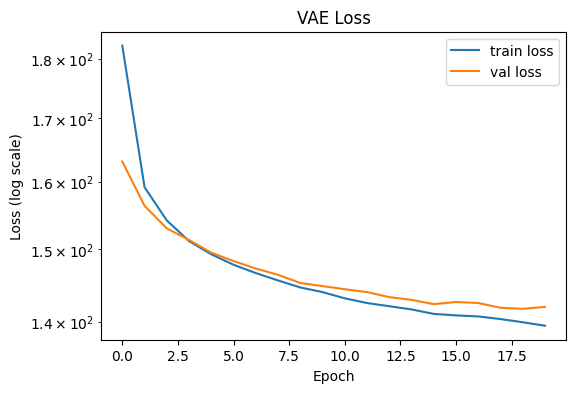

In [9]:
# --- Visualizar curvas de perda ---
train_loss = [t[0] for t in train_logs]
val_loss = [v[0] for v in val_logs]
plt.figure(figsize=(6,4))
plt.plot(train_loss, label="train loss")
plt.plot(val_loss, label="val loss")
plt.yscale("log")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss (log scale)")
plt.title("VAE Loss")
plt.savefig(os.path.join(out_dir, "loss_curve.png"))
plt.show()


## Generated Samples from the Latent Space

The VAE successfully generates coherent digit-like samples by decoding random latent vectors sampled from a standard normal distribution.

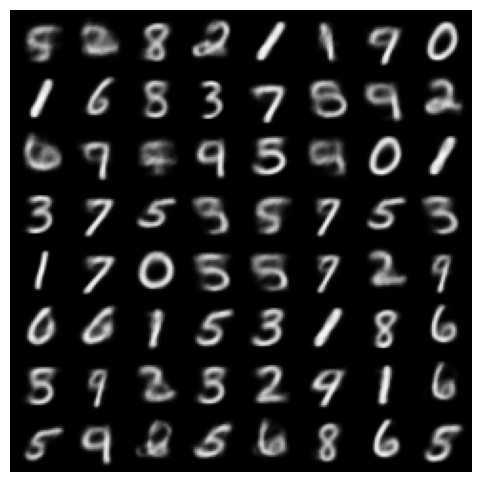

In [ ]:
n_samples = 64
with torch.no_grad():
    z = torch.randn(n_samples, latent_dim).to(device)
    samples = model.decoder(z)
    utils.save_image(samples, os.path.join(out_dir, "samples_prior.png"), nrow=8)
    plt.figure(figsize=(6,6))
    plt.axis("off")
    plt.imshow(utils.make_grid(samples.cpu(), nrow=8).permute(1,2,0).squeeze())
    plt.show()


## Latent Space

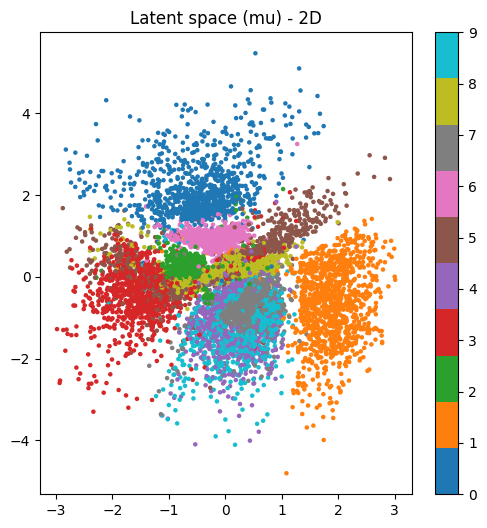

In [11]:
# --- Visualizar espaço latente (latent_dim <=3: scatter, caso contrário usar PCA/t-SNE) ---
# Vamos obter mu do conjunto de teste (ou validação) para representar cada imagem com seu mu
model.eval()
zs = []
labels = []
with torch.no_grad():
    for x, y in test_loader:
        x = x.to(device)
        mu, logvar = model.encoder(x)
        zs.append(mu.cpu().numpy())
        labels.append(y.numpy())
zs = np.concatenate(zs, axis=0)
labels = np.concatenate(labels, axis=0)

if latent_dim == 2:
    plt.figure(figsize=(6,6))
    sc = plt.scatter(zs[:,0], zs[:,1], c=labels, cmap="tab10", s=5)
    plt.colorbar(sc, ticks=range(10))
    plt.title("Latent space (mu) - 2D")
    plt.savefig(os.path.join(out_dir, "latent_2d.png"))
    plt.show()
else:
    # usar PCA e t-SNE
    pca = PCA(n_components=2)
    z_pca = pca.fit_transform(zs)
    plt.figure(figsize=(6,6))
    plt.scatter(z_pca[:,0], z_pca[:,1], c=labels, s=5, cmap="tab10")
    plt.title("Latent space projected with PCA")
    plt.savefig(os.path.join(out_dir, "latent_pca.png"))
    plt.show()

    tsne = TSNE(n_components=2, perplexity=30, init='pca', random_state=seed)
    z_tsne = tsne.fit_transform(zs[:5000])  # por performance, usar subset
    labs = labels[:5000]
    plt.figure(figsize=(6,6))
    plt.scatter(z_tsne[:,0], z_tsne[:,1], c=labs, s=5, cmap="tab10")
    plt.title("Latent space projected with t-SNE (subset)")
    plt.savefig(os.path.join(out_dir, "latent_tsne.png"))
    plt.show()


## Reconstructions
The model successfully reconstructs digits, preserving the general shape and structure.  
Some blurring and noise are expected due to the probabilistic nature of the VAE.

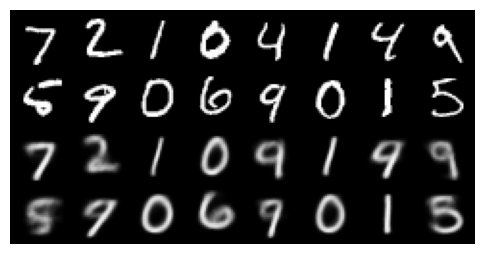

In [12]:
# --- Reconstrução lado a lado (exibir/guardar) ---
# Carregar algumas imagens test e mostrar original vs recon
with torch.no_grad():
    x, _ = next(iter(test_loader))
    x = x[:16].to(device)
    x_hat, _, _, _ = model(x)
    comp = torch.cat([x, x_hat])
    utils.save_image(comp, os.path.join(out_dir, "reconstructions.png"), nrow=8)
    plt.figure(figsize=(6,4))
    plt.axis("off")
    plt.imshow(utils.make_grid(comp.cpu(), nrow=8).permute(1,2,0).squeeze())
    plt.show()
